### Dockless scooters exploration

In [112]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from fiona.crs import from_epsg
from geopandas.tools import sjoin
import networkx as nx
try:
    import urllib as urllib
except ImportError:
    import urllib3 as urllib
import requests
import zipfile
import io
pd.set_option('display.max_columns', 50)
import matplotlib.pyplot as plt
from fiona.crs import from_epsg
import pysal as ps
%matplotlib inline

ImportError: No module named pysal

#### Data cleaning has been done in Preprocessing so, we will just read ion the processed data.

In [35]:
dockless = pd.read_csv('Dockless_data_Austin.csv',infer_datetime_format=True,\
                       parse_dates=['start_time','end_time'],encoding='ascii')

#### Checking how the dataframe looks

In [36]:
dockless.head()

,id,device_id,vehicle_type,trip_duration,trip_distance,start_time,end_time,modified_date,month,hour,day_of_week,council_district_start,council_district_end,origin_cell_id,destination_cell_id,year,start_latitude,start_longitude,end_latitude,end_longitude
0,000000cb-78a9-4b95-8ead-37c797abcf37,ad14e63b-940d-4ca3-84c6-0131147fba45,scooter,358.0,915.0,2018-06-29 17:30:00,2018-06-29 17:30:00,12/12/2018 09:36:14 PM,6.0,17.0,5.0,5.0,9.0,13445.0,13916.0,2018.0,30.263,-97.762,30.259,-97.754
1,00001b5f-46aa-4b26-a12f-d7b4d3c69834,c5a230c9-7e80-4464-862f-f2b23f61d6d3,scooter,226.0,839.0,2018-11-30 11:00:00,2018-11-30 11:00:00,12/13/2018 03:43:44 PM,11.0,11.0,5.0,9.0,9.0,14556.0,15186.0,2018.0,30.283,-97.745,30.284,-97.737
2,00002334-2f2b-41a0-9a04-8ff66be39f40,5a9f7815-bf0c-4fef-8bac-60efd4f23b10,scooter,324.0,1206.0,2018-10-02 15:15:00,2018-10-02 15:30:00,12/13/2018 03:49:54 PM,10.0,15.0,2.0,9.0,9.0,15344.0,15032.0,2018.0,30.285,-97.734,30.291,-97.738
3,0000261e-c0f0-4fb1-9947-1606dfe4ddcf,41fa0cf0-f433-4b3a-89f5-2c6cec6c367d,scooter,1096.0,0.0,2018-09-02 16:45:00,2018-09-02 17:00:00,12/13/2018 03:53:09 PM,9.0,16.0,0.0,9.0,9.0,14707.0,14081.0,2018.0,30.268,-97.743,30.276,-97.752
4,00002c70-678b-4c09-a32c-da0266e329c6,ddd4bbc3-114e-4cbc-b078-860e3c28b11b,scooter,408.0,1144.0,2018-09-28 11:45:00,2018-09-28 11:45:00,12/12/2018 10:24:56 PM,9.0,11.0,5.0,3.0,3.0,16114.0,15642.0,2018.0,30.242,-97.721,30.244,-97.729


In [37]:
## Seeing if the columns have appropriate datatypes
dockless.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2612879 entries, 0 to 2612878
Data columns (total 20 columns):
id                        object
device_id                 object
vehicle_type              object
trip_duration             float64
trip_distance             float64
start_time                datetime64[ns]
end_time                  datetime64[ns]
modified_date             object
month                     float64
hour                      float64
day_of_week               float64
council_district_start    float64
council_district_end      float64
origin_cell_id            float64
destination_cell_id       float64
year                      float64
start_latitude            float64
start_longitude           float64
end_latitude              float64
end_longitude             float64
dtypes: datetime64[ns](2), float64(14), object(4)
memory usage: 398.7+ MB


In [61]:
dockless.shape

(2612879, 20)

In [39]:
len(dockless.id.unique())

2612879

In [42]:
dockless_sub = dockless[:100000]

In [45]:
dockless_sub.drop(['vehicle_type','modified_date'],axis=1,inplace=True)

In [58]:
dockless_sub.dropna(inplace=True)

/anaconda3/envs/nishi/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [74]:
dockless_sub.groupby(['council_district_start','council_district_end']).count()[['id']]

id
council_district_start council_district_end       
0.0                    0.0                      23
                       8.0                       3
                       9.0                       1
1.0                    1.0                    2984
                       3.0                     277
                       4.0                      10
                       5.0                      16
                       7.0                       3
                       8.0                       7
                       9.0                    2619
                       10.0                      2
2.0                    0.0                       1
                       1.0                       1
                       2.0                      83
                       3.0                      14
                       5.0                       5
                       9.0                       8
3.0                    1.0                     275
                       2.0                      20
                       3.0                    4580
                       4.0                       1
                       5.0                      73
                       7.0                       2
                       8.0                       8
                       9.0                    1637
                       10.0                      3
4.0                    0.0                       1
                       1.0                      14
                       4.0                     258
                       7.0                      20
...                                            ...
7.0                    1.0                       3
                       4.0                      35
                       5.0                       1
                       7.0                     922
                       9.0                      32
                       10.0                     19
8.0                    0.0                       4
                       1.0                       3
                       3.0                       2
                       5.0                      87
                       8.0                     293
                       9.0                     125
                       10.0                      8
9.0                    0.0                       2
                       1.0                    3087
                       2.0                       4
                       3.0                    2036
                       4.0                      92
                       5.0                    1350
                       7.0                      40
                       8.0                     206
                       9.0                   74616
                       10.0                    153
10.0                   1.0                       1
                       5.0                       4
                       6.0                       2
                       7.0                      18
                       8.0                       1
                       9.0                     131
                       10.0                    388

[74 rows x 1 columns]

![Austin_Council_Districts](Austin_council_districts.png)

#### So, the number of rides originating in each council district kind of make sense,as district 9 has the most number of rides and it represents the city center.

In [62]:
FG = nx.from_pandas_dataframe(dockless_sub, source='council_district_start', target='council_district_end', edge_attr=True)

In [63]:
FG.nodes()

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

In [64]:
FG.edges()

[(0.0, 0.0),
 (0.0, 2.0),
 (0.0, 4.0),
 (0.0, 5.0),
 (0.0, 7.0),
 (0.0, 8.0),
 (0.0, 9.0),
 (1.0, 1.0),
 (1.0, 2.0),
 (1.0, 3.0),
 (1.0, 4.0),
 (1.0, 5.0),
 (1.0, 7.0),
 (1.0, 8.0),
 (1.0, 9.0),
 (1.0, 10.0),
 (2.0, 2.0),
 (2.0, 3.0),
 (2.0, 5.0),
 (2.0, 9.0),
 (3.0, 3.0),
 (3.0, 4.0),
 (3.0, 5.0),
 (3.0, 7.0),
 (3.0, 8.0),
 (3.0, 9.0),
 (3.0, 10.0),
 (4.0, 4.0),
 (4.0, 5.0),
 (4.0, 7.0),
 (4.0, 9.0),
 (4.0, 10.0),
 (5.0, 5.0),
 (5.0, 7.0),
 (5.0, 8.0),
 (5.0, 9.0),
 (5.0, 10.0),
 (6.0, 10.0),
 (6.0, 6.0),
 (6.0, 7.0),
 (7.0, 7.0),
 (7.0, 9.0),
 (7.0, 10.0),
 (8.0, 8.0),
 (8.0, 9.0),
 (8.0, 10.0),
 (9.0, 9.0),
 (9.0, 10.0),
 (10.0, 10.0)]

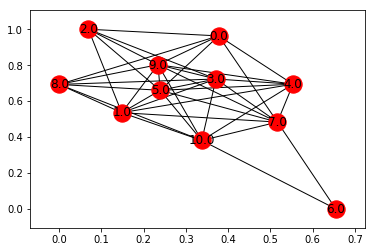

In [66]:
nx.draw_networkx(FG, with_labels=True)

In [69]:
nx.degree_centrality(FG)

{0.0: 0.8,
 1.0: 1.0,
 2.0: 0.7000000000000001,
 3.0: 1.0,
 4.0: 0.9,
 5.0: 1.1,
 6.0: 0.4,
 7.0: 1.0,
 8.0: 0.8,
 9.0: 1.1,
 10.0: 1.0}

In [77]:
#Combine lat long into a tuple column
dockless_sub['lonlat'] = list(zip(dockless_sub.start_longitude, dockless_sub.start_latitude))
#Create Point feature in geometry column
dockless_sub['geometry'] = dockless_sub.lonlat.apply(lambda x: shapely.geometry.Point(x))
#Create GeoDataFrame
dockless_sub_gdf = gpd.GeoDataFrame(dockless_sub)
#Set CRS
dockless_sub_gdf.crs = from_epsg(4326)

/anaconda3/envs/nishi/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/envs/nishi/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [141]:
min(dockless_sub_gdf.start_time)

Timestamp('2018-04-05 11:30:00')

In [142]:
dockless_sub_gdf.head()

,id,device_id,trip_duration,trip_distance,start_time,end_time,month,hour,day_of_week,council_district_start,council_district_end,origin_cell_id,destination_cell_id,year,start_latitude,start_longitude,end_latitude,end_longitude,lonlat,geometry
0,000000cb-78a9-4b95-8ead-37c797abcf37,ad14e63b-940d-4ca3-84c6-0131147fba45,358.0,915.0,2018-06-29 17:30:00,2018-06-29 17:30:00,6.0,17.0,5.0,5.0,9.0,13445.0,13916.0,2018.0,30.263,-97.762,30.259,-97.754,"(-97.762, 30.263)",POINT (-97.762 30.263)
1,00001b5f-46aa-4b26-a12f-d7b4d3c69834,c5a230c9-7e80-4464-862f-f2b23f61d6d3,226.0,839.0,2018-11-30 11:00:00,2018-11-30 11:00:00,11.0,11.0,5.0,9.0,9.0,14556.0,15186.0,2018.0,30.283,-97.745,30.284,-97.737,"(-97.745, 30.283)",POINT (-97.745 30.283)
2,00002334-2f2b-41a0-9a04-8ff66be39f40,5a9f7815-bf0c-4fef-8bac-60efd4f23b10,324.0,1206.0,2018-10-02 15:15:00,2018-10-02 15:30:00,10.0,15.0,2.0,9.0,9.0,15344.0,15032.0,2018.0,30.285,-97.734,30.291,-97.738,"(-97.734, 30.285)",POINT (-97.73399999999999 30.285)
3,0000261e-c0f0-4fb1-9947-1606dfe4ddcf,41fa0cf0-f433-4b3a-89f5-2c6cec6c367d,1096.0,0.0,2018-09-02 16:45:00,2018-09-02 17:00:00,9.0,16.0,0.0,9.0,9.0,14707.0,14081.0,2018.0,30.268,-97.743,30.276,-97.752,"(-97.743, 30.268)",POINT (-97.74299999999999 30.268)
4,00002c70-678b-4c09-a32c-da0266e329c6,ddd4bbc3-114e-4cbc-b078-860e3c28b11b,408.0,1144.0,2018-09-28 11:45:00,2018-09-28 11:45:00,9.0,11.0,5.0,3.0,3.0,16114.0,15642.0,2018.0,30.242,-97.721,30.244,-97.729,"(-97.721, 30.242)",POINT (-97.721 30.242)


In [153]:
len(dockless[dockless['month']==11].device_id.unique())

12362

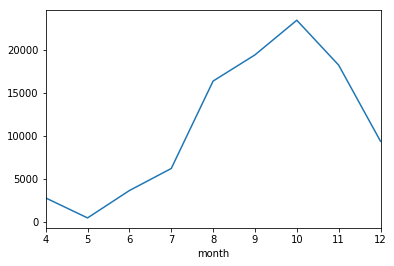

In [139]:
dockless_sub_gdf.groupby('month').count()['id'].plot()

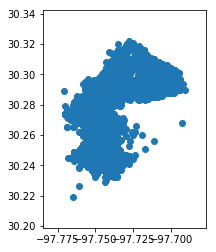

In [80]:
dockless_sub_gdf[dockless_sub_gdf.council_district_start==9].plot()

In [ ]:
https://data.austintexas.gov/api/geospatial/hdpc-ysmz?method=export&format=Shapefile

In [101]:
url = "https://data.austintexas.gov/api/geospatial/hdpc-ysmz?method=export&format=Shapefile"
print('Downloading shapefile...')
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
print("Done")
z.extractall(path='council_districts/') # extract to folder
filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
print(filenames)

Done
[u'geo_export_581466aa-8d68-4447-8cd4-ede64de1e69f.dbf', u'geo_export_581466aa-8d68-4447-8cd4-ede64de1e69f.prj', u'geo_export_581466aa-8d68-4447-8cd4-ede64de1e69f.shp', u'geo_export_581466aa-8d68-4447-8cd4-ede64de1e69f.shx']


In [104]:
dbf, prj, shp, shx = [filename for filename in filenames]
council_districts = gpd.read_file('council_districts/'+shp)

In [105]:
council_districts.head()

,council_di,created_by,date_creat,time_creat,modified_b,date_modif,time_modif,objectid,shape_area,shape_leng,single_mem,geometry
0,http://www.austintexas.gov/department/district-3,meekss,2018-06-14,11:00:25.000,lockwoodg,2016-10-18,13:41:59.000,1.0,5.027911e+08,153982.266647,400378072.0,"(POLYGON ((-97.680452610835 30.267642217703, -..."
1,http://www.austintexas.gov/department/district-4,meekss,2018-06-14,11:00:26.000,lockwoodg,2016-10-18,13:42:05.000,3.0,3.308754e+08,105092.713667,400378084.0,"POLYGON ((-97.70834462297 30.392488241669, -97..."
2,http://www.austintexas.gov/department/district-2,meekss,2018-06-14,11:00:26.000,lockwoodg,2016-10-18,13:41:55.000,2.0,1.290120e+09,689873.424949,400378076.0,"(POLYGON ((-97.718093991782 30.184857710517, -..."
3,http://www.austintexas.gov/department/district-9,meekss,2018-06-14,11:00:26.000,lockwoodg,2016-10-18,13:42:32.000,4.0,3.482170e+08,135780.245550,400378086.0,"POLYGON ((-97.731632625359 30.317929225339, -9..."
4,http://www.austintexas.gov/department/district-5,meekss,2018-06-14,11:00:25.000,meekss,2018-03-30,16:36:17.000,8.0,6.719064e+08,343441.587183,400378068.0,"(POLYGON ((-97.79137132583099 30.093084953282,..."


In [113]:
type(council_districts)

geopandas.geodataframe.GeoDataFrame

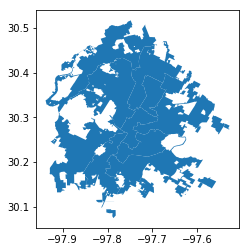

In [119]:
ax = council_districts.plot()

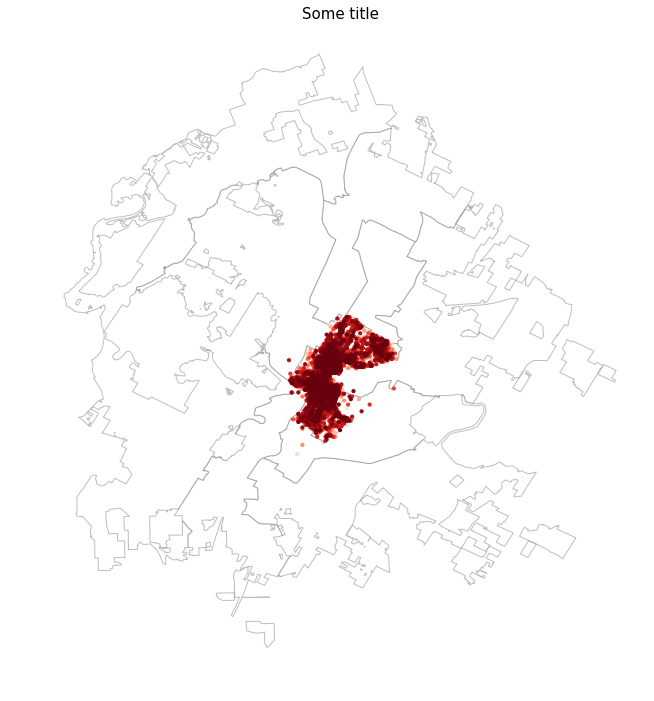

In [158]:
fig, ax = plt.subplots(figsize  = (12, 12))

ax.set_title("Some title", fontsize=15)

council_districts.plot(ax=ax, legend=True, scheme='Equal_Interval', k=5, color="white", edgecolor='grey', lw=1,alpha=0.5)

ax.axis('off')
# leg = ax.get_legend()
# leg.set_bbox_to_anchor((0.35, 0.95, 0, 0))

dockless_sub_gdf[dockless_sub_gdf.council_district_start==9].plot(ax=ax, cmap='Reds', markersize=10)

#Correct aspect ratio
ax.axes.set_aspect('equal')

plt.show()

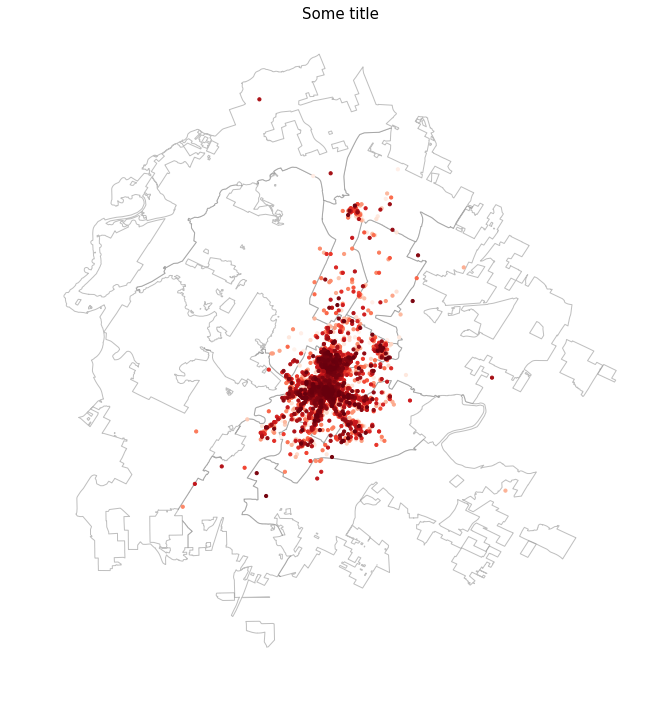

In [157]:
fig, ax = plt.subplots(figsize  = (12, 12))

ax.set_title("Some title", fontsize=15)

council_districts.plot(ax=ax, legend=True, scheme='Equal_Interval', k=5, color="white", edgecolor='grey', lw=1,alpha=0.5)

ax.axis('off')
# leg = ax.get_legend()
# leg.set_bbox_to_anchor((0.35, 0.95, 0, 0))

dockless_sub_gdf[dockless_sub_gdf['hour']==16].plot(ax=ax, cmap='Reds', markersize=10)

#Correct aspect ratio
ax.axes.set_aspect('equal')

plt.show()

In [114]:
max(dockless.start_time)

Timestamp('2019-02-12 06:15:00')

In [115]:
min(dockless.start_time)

Timestamp('2018-04-03 18:30:00')

In [117]:
import time
a= time.time()

In [118]:
time.time() - a

7.398709058761597